# Os Silkers

In [1]:
from load_history import load_history
from train import train
from predict import predict
import polars as pl

In [2]:
df_pdvs = pl.read_parquet('/home/guilherme/code/python/OsSilkers/data/parquet/pdvs.parquet')
df_produtos = pl.read_parquet('/home/guilherme/code/python/OsSilkers/data/parquet/produtos.parquet')
df_vendas = pl.read_parquet('/home/guilherme/code/python/OsSilkers/data/parquet/vendas.parquet')

In [3]:
df = df_vendas.join(df_produtos, left_on='internal_product_id', right_on='produto')
df = df.join(df_pdvs, left_on='internal_store_id', right_on='pdv')

original_df = df

In [4]:
df, _ = load_history(df)
df, _

(shape: (6_205_747, 13)
 ┌─────────────┬─────────────┬────────────┬─────────────┬───┬─────────────┬────────────┬─────┬──────┐
 │ pdv         ┆ sku         ┆ semana     ┆ vendas_sema ┆ … ┆ desvio_padr ┆ semana_do_ ┆ mes ┆ ano  │
 │ ---         ┆ ---         ┆ ---        ┆ nais        ┆   ┆ ao_4_semana ┆ ano        ┆ --- ┆ ---  │
 │ str         ┆ str         ┆ date       ┆ ---         ┆   ┆ s           ┆ ---        ┆ i8  ┆ i32  │
 │             ┆             ┆            ┆ f64         ┆   ┆ ---         ┆ i8         ┆     ┆      │
 │             ┆             ┆            ┆             ┆   ┆ f64         ┆            ┆     ┆      │
 ╞═════════════╪═════════════╪════════════╪═════════════╪═══╪═════════════╪════════════╪═════╪══════╡
 │ 10002374870 ┆ 18374296073 ┆ 2022-02-07 ┆ 1.0         ┆ … ┆ null        ┆ 6          ┆ 2   ┆ 2022 │
 │ 41964405    ┆ 27399565    ┆            ┆             ┆   ┆             ┆            ┆     ┆      │
 │ 10002374870 ┆ 18374296073 ┆ 2022-02-14 ┆ 2.0         ┆ 

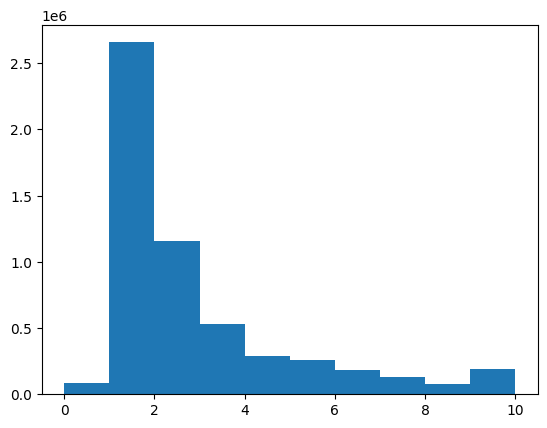

In [5]:
import matplotlib.pyplot as plt

plt.hist(df.to_pandas()['vendas_semanais'].to_numpy(), range=[0, 10])
plt.show()

In [6]:
model = train(df)

         vendas_lag_1  vendas_lag_2  vendas_lag_3  vendas_lag_4  \
0                 0.0           0.0           0.0           0.0   
1                 1.0           0.0           0.0           0.0   
2                 2.0           1.0           0.0           0.0   
3                 1.0           2.0           1.0           0.0   
4                 2.0           1.0           2.0           1.0   
...               ...           ...           ...           ...   
6205742           1.0           0.0           0.0           0.0   
6205743           1.0           1.0           0.0           0.0   
6205744           1.0           1.0           1.0           0.0   
6205745           1.0           1.0           1.0           1.0   
6205746           1.0           1.0           1.0           1.0   

         media_movel_4_semanas  desvio_padrao_4_semanas  semana_do_ano  mes  \
0                          0.0                  0.00000              6    2   
1                          0.0       

In [7]:
from filter_most_relevant import filter_most_valuable_inputs
combinations_to_use = filter_most_valuable_inputs(original_df, 300000)

In [8]:
combinations_to_use

internal_store_id,internal_product_id,gross_value
str,str,f64
"""4307001887067073751""","""8317287899207839970""",59754.959717
"""5077327874228029971""","""4439123428195264029""",44064.620712
"""5077327874228029971""","""7029448080469668619""",38239.199951
"""5077327874228029971""","""1023598837563683985""",31170.850006
"""4307001887067073751""","""401938770626448498""",30410.40094
…,…,…
"""6604594728328935671""","""2120799115839400862""",67.049999
"""4521973704454050208""","""1174558658383487316""",67.049999
"""7270939239281710066""","""2777480352243393897""",67.049999


In [9]:
filtered_df = df.join(combinations_to_use, left_on=['pdv', 'sku'], right_on=['internal_store_id', 'internal_product_id'], how='semi')

In [10]:
predictions = predict(1, 1, 2023, model, filtered_df, '.')

/home/guilherme/code/python/OsSilkers/src/predict.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_df = pd.concat([four_weeks_df, new_original_df])


Initializing predictions for 2023-01-01 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predicted_values_df = concat_df.rename({


End of predictions for 2023-01-01 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_df = pd.concat([concat_df, new_original_df])


Initializing predictions for 2023-01-08 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predicted_values_df = concat_df.rename({


End of predictions for 2023-01-08 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_df = pd.concat([concat_df, new_original_df])


Initializing predictions for 2023-01-15 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predicted_values_df = concat_df.rename({


End of predictions for 2023-01-15 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_df = pd.concat([concat_df, new_original_df])


Initializing predictions for 2023-01-22 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predicted_values_df = concat_df.rename({


End of predictions for 2023-01-22 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_df = pd.concat([concat_df, new_original_df])


Initializing predictions for 2023-01-29 00:00:00
End of predictions for 2023-01-29 00:00:00


/home/guilherme/code/python/OsSilkers/src/predict.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predicted_values_df = concat_df.rename({


In [25]:
predictions = predictions.astype('int')

In [26]:
predictions_positive = predictions.drop(predictions[predictions['quantidade'] < 0].index)

In [27]:
predictions_positive.sort_values(['quantidade'], ascending=False)

,semana,pdv,produto,quantidade
75235,1,1915577311444334326,8988637221428669939,113
459337,1,6825966060938407713,7520814577634754406,113
564791,1,806485401242243256,347520348779130794,112
581342,1,826295652279312225,4324163610483670143,111
572255,1,8147878783243294465,5136943744002676740,110
...,...,...,...,...
633158,1,889771664964471946,5418855670645487653,0
480418,1,7126858116544870884,7852170368684115755,0
543404,1,7804336417165452100,3262679882836704514,0
633299,1,8900976794488847926,7170592116007465797,0


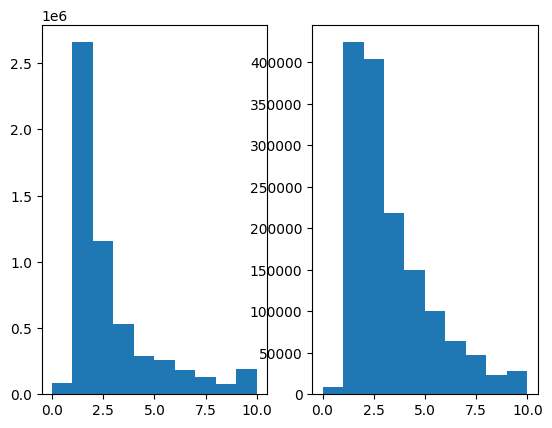

In [24]:
import matplotlib.pyplot as plt


dataset_qts = df.to_pandas()['vendas_semanais'].to_numpy()
predicted_qts = predictions['quantidade'].to_numpy()

axes = plt.subplot(1, 2, 1)
axes.hist(dataset_qts, range=[0, 10])
limit = [0, 5e6]
#axes.set_xlim(limit)
axes2 = plt.subplot(1, 2, 2)
#axes2.set_xlim()
axes2.hist(predicted_qts, range=[0, 10])
plt.show()

In [28]:
predictions_positive.drop_duplicates(subset=['pdv', 'produto'])

,semana,pdv,produto,quantidade
667018,1,969121616954361713,1271951761907094129,9
635373,1,8924888785538844515,347520348779130794,1
634828,1,8918984701561076,3262679882836704514,7
635498,1,8926962086626844375,3965996009832298069,9
479387,1,7113140611742290685,2584866940179463290,5
...,...,...,...,...
672669,2,6893060203230784871,5600821899766970056,5
394363,3,3787872365761289322,3840201750077926393,2
14850,3,1082484277848519785,6127456226485495086,2
46394,3,1295516380043070490,1271951761907094129,3


In [30]:
predictions_positive.to_parquet('../saved/OsSilkers_Final.parquet')